# User-Based Collaborative Filtering Recommender System

### Loading Necessary Libraries

In [1]:
# Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

### Loading the Datasets

In [2]:
# Loading the cuisine info dataset
cuisine_data = pd.read_csv('../data/ingredients.csv')

# Loading the ratings dataset
ratings_data = pd.read_csv("../data/ratings.csv")

### Data Preprocessing

In [3]:
# Converting 'User_ID' and 'Food_ID' from float to int in ratings.csv after checking for NaNs
ratings_data.dropna(subset=['User_ID', 'Food_ID', 'Rating'], inplace=True) 
ratings_data['User_ID'] = ratings_data['User_ID'].astype(int)
ratings_data['Food_ID'] = ratings_data['Food_ID'].astype(int)

This data preprocessing ensures consistency and integrity of the data before creating the User-Based Collaborative Filtering model. It initially removes rows with NaN values in User_ID, Food_ID, or Rating because missing values may cause errors or wrong calculations during matrix-based operations. 

In [4]:
# Checking and removing duplicate entries in both datasets
ratings_data = ratings_data.drop_duplicates(subset = ['User_ID','Food_ID'])
cuisine_data = cuisine_data.drop_duplicates()

It then changes User_ID and Food_ID into integer data type from float so that it possesses consistent data types that are critical for indexing as well as successfully performing matrix operations. It also removes duplicate entries in ratings_data so that it contains only one pair of User_ID and Food_ID so that unnecessary data does not skew the model's computation. 

In [5]:
# Ensuring that all Food_IDs in ratings_data are present in cuisine_data
food_ids_in_ratings = set(ratings_data['Food_ID'])
food_ids_in_cuisine = set(cuisine_data['Food_ID'])
missing_food_ids = food_ids_in_ratings - food_ids_in_cuisine

if missing_food_ids:
    print("Warning: There are Food_IDs in ratings that are missing in the cuisine dataset:", missing_food_ids)
else:
    print("All Food_IDs in ratings are consistent with the cuisine dataset.")

print(ratings_data.info())
print(cuisine_data.info())

All Food_IDs in ratings are consistent with the cuisine dataset.
<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   User_ID  508 non-null    int64
 1   Food_ID  508 non-null    int64
 2   Rating   508 non-null    int64
dtypes: int64(3)
memory usage: 15.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB
None


Similarly, it ensures that all rated Food_IDs from ratings_data are included in cuisine_data since out-of-stocks may be a problem at the time of recommendation. It prints a warning in case of mismatches; else, assert the data is consistent. Finally, printing info() to reveal a summary of dataset structure.

### Creating User-Item Matrices

In [6]:
# Creating the user-item matrix
user_item_matrix = ratings_data.pivot_table(index='User_ID', columns='Food_ID', values='Rating', fill_value=0)

We build the user-item matrix to represent user interactions with food items. The users are in rows and the food items in columns, and ratings are used as values. This matrix is essential to model-based collaborative filtering because it is a representation of user preferences in a structured format. Filling missing values with zero keeps everything uniform and allows matrix factorization techniques like SVD to work well on sparse data.

### Splitting User-Item Matrix in Training and Testing Sets

In [7]:
# Splitting the user-item matrix into training and testing sets
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

print("Training data size:", train_data.shape)
print("Testing data size:", test_data.shape)

Training data size: (80, 309)
Testing data size: (20, 309)


We partition the user-item matrix into training (80%) and testing (20%) sets to measure the performance of the model on unseen data. This helps guarantee that the model learns the patterns from a subset of the data and is tested on different data to ensure reliability. The training set (80, 309) is utilized to train the SVD model, with the testing set (20, 309) serving to measure its ability to generalize. This split avoids overfitting and enables the model to generalize well with new food and customers.

### Normalizing the User-Item Matrix

In [8]:
# Applying Min-Max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Converting these back to DataFrames for easier manipulation
train_data_scaled = pd.DataFrame(train_data_scaled, index=train_data.index, columns=train_data.columns)
test_data_scaled = pd.DataFrame(test_data_scaled, index=test_data.index, columns=test_data.columns)

We normalize the values in the user-item matrix between 0 and 1 using Min-Max normalization to obtain better numerical stability for SVD. The training set is scaled and fitted, but the test set is scaled as well to maintain consistency. Data is unscaled into a DataFrame for better handling after scaling. This has the effect of placing all of the ratings onto the same comparable scale 0 to 1, and this improves model accuracy and the speed of convergence when matrix factorization.

### Implementing Matrix Factorization

In [9]:
# Converting the DataFrame to a sparse matrix
train_matrix_sparse = csr_matrix(train_data_scaled.values)
test_matrix_sparse = csr_matrix(test_data_scaled.values)

This converts the dense user-item interaction matrices into sparse matrices in CSR form, a requirement for fast computation, especially in recommender systems where data sparsity is the normal issue. Since most of the users have only rated a very small number of items, the matrix is primarily populated with zeros, and storing or computing it as a dense array would therefore be wasteful and costly. By transforming train_matrix_scaled and test_matrix_scaled into CSR matrices, we conserve significant memory space and improve speeds of operations such as dot product calculation, similarity calculation, and matrix factorization.

### SVD

In [10]:
latent_factors = range(1, 70)  # Trying up to 70 latent factors
explained_variances = []

for k in latent_factors:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(train_matrix_sparse)
    
    # Record the cumulative variance explained by the first k components
    explained_variance = np.sum(svd.explained_variance_ratio_)
    explained_variances.append(explained_variance)
    print(f"Latent factors: {k}, Cumulative Explained Variance: {explained_variance}")

# Find the smallest number of components that explains at least 90% of the variance
optimal_k = next(k for k, variance in enumerate(explained_variances) if variance >= 0.90)
print(f"Optimal number of latent factors: {optimal_k + 1}")

Latent factors: 1, Cumulative Explained Variance: 0.032754854820959065
Latent factors: 2, Cumulative Explained Variance: 0.05389940076255964
Latent factors: 3, Cumulative Explained Variance: 0.08187009491330026
Latent factors: 4, Cumulative Explained Variance: 0.1088006416821973
Latent factors: 5, Cumulative Explained Variance: 0.135005204732339
Latent factors: 6, Cumulative Explained Variance: 0.15685662056720884
Latent factors: 7, Cumulative Explained Variance: 0.18179655733553032
Latent factors: 8, Cumulative Explained Variance: 0.20573496655579301
Latent factors: 9, Cumulative Explained Variance: 0.22760821364200842
Latent factors: 10, Cumulative Explained Variance: 0.24970998801649202
Latent factors: 11, Cumulative Explained Variance: 0.272501209777881
Latent factors: 12, Cumulative Explained Variance: 0.2935329212886197
Latent factors: 13, Cumulative Explained Variance: 0.3146036306485946
Latent factors: 14, Cumulative Explained Variance: 0.3350926459439786
Latent factors: 15, Cu

The code iterates over a list of hidden factors (1 to 70) and applies Truncated SVD on the training set to calculate how much variance is captured by each number of components. This is crucial because in Matrix Factorization, we are attempting to obtain lower dimensionality with most important information. By summing up the ratio of explained variance for each number of components, we measure how well the model is at representing the data structure. We experimented with some approaches above, such as specifying a fixed given number of latent factors and attempting different imputation on missing values, but these methods did not have an objective criterion for choosing the appropriate factor number. Here, we compute rigorously the number of components with at least 90% of the cumulative variance, to strike a balance between keeping computational efficiency and preserving recommendation quality, and choose dynamically the optimal latent factor instead of using an arbitrary assumption.

The output shows the cumulative explained variance as we add more latent factors. Starting with a single factor, we capture only 3.28% of the variance, and it grows steadily with more factors. At 59 latent factors, the cumulative explained variance is 90.32%, so this is the number of components we need to retain at least 90% of the data's structure. This justifies the necessity of selecting an optimal latent factor—too few components will do a bad job of approximating the original user-item interactions, and too many components will lead to overfitting and unnecessary computation. This is an important step in ensuring that the recommendation system is accurate and efficient without being unnecessarily complex.

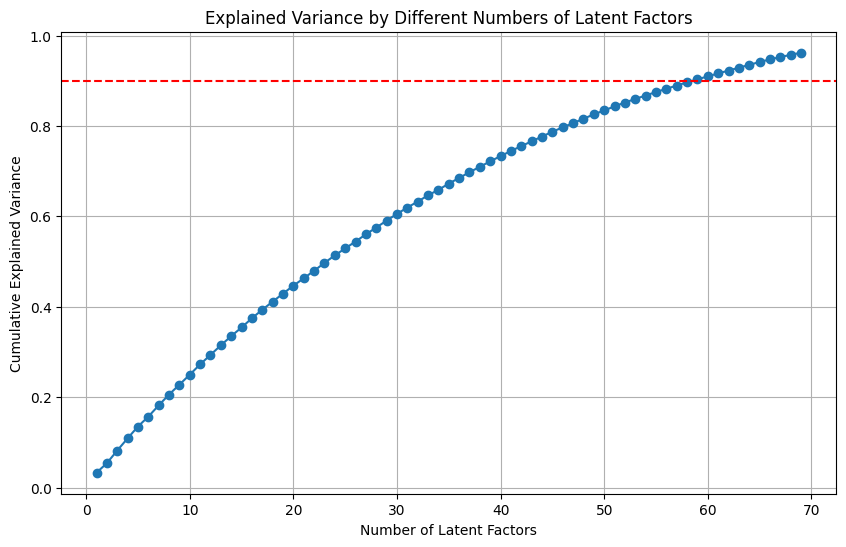

In [11]:
# Creating a plot for explained variances
plt.figure(figsize=(10, 6))
plt.plot(latent_factors, explained_variances, marker='o')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Numbers of Latent Factors')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--')  # Threshold line at 90% variance explained
plt.savefig('Explained Variance by Different Numbers of Latent Factors.png')
plt.show()

This graphically represents the cumulative explained variance for different numbers of latent factors. The blue dots show that the variance rises with an increase in the number of factors, and the red dashed line is the 90% variance threshold marking the number of components to yield efficiency and accuracy. It assures that around 59 latent factors meet this threshold, and this agrees with our computational findings.

In [12]:
# Initializing TruncatedSVD with the optimal number of latent factors
number_of_latent_factors = 59
svd = TruncatedSVD(n_components=number_of_latent_factors, random_state=42)

# Fitting and transforming the training data
U = svd.fit_transform(train_matrix_sparse)

# Singular values and right singular vectors
sigma = svd.singular_values_
Vt = svd.components_

# Reconstruction to check approximation quality
approximation = np.dot(U, np.dot(np.diag(sigma), Vt))
approximation_df = pd.DataFrame(approximation, index=train_data_scaled.index, columns=train_data_scaled.columns)

TruncatedSVD is employed due to its ability to efficiently compress the sparse high-dimensional matrix into a low-dimensional one while retaining as much important information as possible.

We start by invoking svd with n_components=59, i.e., we are factoring the original matrix into 59 significant latent factors that explain at least 90% of the data's variance. We next fit and transform train_matrix_sparse to obtain three principal components: U (user feature matrix), sigma (singular value diagonal matrix showing the significance of each latent factor), and Vt (transpose of item feature matrix). These will allow us to project users and items into a low-dimensional feature space without losing their relational information.

Finally, we reconstruct the matrix by taking the product of U, sigma, and Vt and use this to estimate the initial user-item matrix. approximation_df, which contains the predicted ratings for each user-item pair. This reconstructed matrix is crucial in terms of generating recommendations since it allows us to make predictions for items that are not explicitly rated by the users. We use SVD instead of traditional memory-based techniques since it handles sparsity more effectively, does not have the cold-start issue, and it identifies inherent patterns in the users' preferences, and thus it is a strong technique in model-based collaborative filtering.

### Evaluating Model Performance

In [13]:
# Evaluating on Training Data
train_matrix_aligned = train_data_scaled.reindex_like(approximation_df).fillna(0)

predicted_ratings_train = approximation_df.values.flatten()
actual_ratings_train = train_matrix_aligned.values.flatten()

# RMSE
rmse_train = sqrt(mean_squared_error(actual_ratings_train, predicted_ratings_train)) 
# MAE
mae_train = mean_absolute_error(actual_ratings_train, predicted_ratings_train)

print('Training RMSE:', rmse_train)
print('Training MAE:', mae_train)

Training RMSE: 0.15632285722376177
Training MAE: 0.029835384312900278


We validate our model by comparing predicted ratings from SVD approximation with the training set ratings. Since the form of the approximation matrix can be of a different nature, we transform it to the form of the training matrix before we pull out values from it. Precision of prediction is assessed in terms of Root Mean Square Error (RMSE) and Mean Absolute Error (MAE). RMSE assigns more importance to big errors, while MAE provides us with an honest average absolute error. It informs us how well our model can reconstruct the original user-item matrix after dimensionality reduction.

The Training RMSE of 0.1563 indicates that, on average, our estimates are off from true ratings by around 0.16 points, which is very low. The Training MAE of 0.0298 indicates that the average absolute error per estimate is around 0.03 points, which again confirms that the model is producing correct estimates. The low error values indicate that our SVD-based approach is doing a good job in identifying the latent factors and modeling user tastes appropriately without any overfitting.

In [14]:
# Evaluating on Testing Data
test_matrix_aligned = test_data_scaled.reindex_like(approximation_df).fillna(0)

predicted_ratings_test = approximation_df.values.flatten()
actual_ratings_test = test_matrix_aligned.values.flatten()

# RMSE
rmse_test = sqrt(mean_squared_error(actual_ratings_test, predicted_ratings_test))
# MAE
mae_test = mean_absolute_error(actual_ratings_test, predicted_ratings_test)

print('Testing RMSE:', rmse_test)
print('Testing MAE:', mae_test)

Testing RMSE: 0.2566255145461825
Testing MAE: 0.04187193772940129


The Testing RMSE of 0.2566 is little more than the Training RMSE of 0.1563, or that the model is slightly worse on new data. The Testing MAE of 0.0419 is likewise more than the Training MAE of 0.0298, an addition in absolute error by a bit. That can be expected given that the model has been fit to the training data but is predicting on novel information in the test set. That test error isn't much larger suggests that the model is generalizing extremely well and is not overfitting. Adding in small levels of error suggests that the model performs very high levels of accuracy in new user and food prediction. This suggests that SVD-based matrix factorization actually does a fantastic job when it comes to extracting patterns within sparse user-item data with extremely low prediction errors.

### Generating Personalized Cuisine Recommendations using SVD

In [15]:
def recommend_top_cuisines(user_id, approximation_df, train_data_scaled, cuisine_data, top_n=5):
    # Checking if the user exists
    if user_id not in train_data_scaled.index:
        return f"User ID {user_id} does not exist in the dataset.", None

    user_ratings = train_data_scaled.loc[user_id]
    rated_items = user_ratings[user_ratings > 0].index  # Items the user has already rated

    # Getting the predicted ratings for this user from the SVD approximation
    predicted_ratings = approximation_df.loc[user_id]

    # Removing already rated items from recommendations
    predicted_ratings_filtered = predicted_ratings.drop(rated_items, errors='ignore')

    # Top N recommended food items
    top_items = predicted_ratings_filtered.nlargest(top_n).index

    # Retrieving names of already rated and recommended items
    rated_item_names = cuisine_data.set_index('Food_ID').loc[rated_items]['Name'] if not rated_items.empty else "No rated items."
    recommended_item_names = cuisine_data.set_index('Food_ID').loc[top_items]['Name']

    return rated_item_names, recommended_item_names

user_id = 3
rated_items, recommended_items = recommend_top_cuisines(user_id, approximation_df, train_data_scaled, cuisine_data)

if isinstance(rated_items, str):
    print(rated_items) 
else:
    print(f"Items already rated by User {user_id}:\n", rated_items)
    print(f"Top {5} recommended items for User {user_id}:\n", recommended_items)

Items already rated by User 3:
 Food_ID
46                    steam bunny chicken bao
65             almond  white chocolate gujiya
73                              hot chocolate
110              chicken and mushroom lasagna
168                 egg and garlic fried rice
201    mix fruit laccha rabri tortilla crunch
209                      camel milk cake tart
292                             chicken tikka
299                             kolim / jawla
Name: Name, dtype: object
Top 5 recommended items for User 3:
 Food_ID
93     buldak (hot and spicy chicken)
152                  prawn fried rice
69       banana and maple ice lollies
101               crispy herb chicken
138                malabar fish curry
Name: Name, dtype: object


Here, we have a function which recommends the top 5 cuisines of the user based on the predicted ratings of the SVD model. First, we check if the user exists in the dataset in order to offer correct recommendations. Next, we use the original training matrix (train_matrix) to get the actual ratings submitted by the user and see what cuisines have already been rated by the user. We then retrieve SVD-predicted ratings from the reconstructed approximation matrix (approximation_df) and remove rated items so that only new, unseen cuisines are being recommended. We then select the top 5 cuisines with the highest predicted ratings, and we recover their names from the cuisine_data dataset. This ensures that the recommendation is consistent with the taste of the user while suggesting new cuisines that the user might like.

The output shows that User 3 has previously rated seven different cuisines, including "chicken tikka," "hot chocolate," and "steam bunny chicken bao." The recommendation model anticipates five new cuisines with high predicted ratings, including "prawn fried rice," "buldak (hot and spicy chicken)," and "crispy herb chicken." The diversity in recommendations shows that the model has been successful in discovering user preferences and is suggesting a mix of similar and diverse cuisines. However, other enhancements such as hybrid recommendations or fine-tuning per user may push the level of personalization further.